# Multi-label Classification

In this exercise we will classify toxic comments from online. 

In [8]:
%matplotlib inline
import re
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


# Data loading

In [9]:
df = pd.read_csv("/dsa/data/DSA-8410/toxic/train.csv", encoding = "ISO-8859-1")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Data exploration

### T1. Show a distribution of comments over toxic categoies.

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


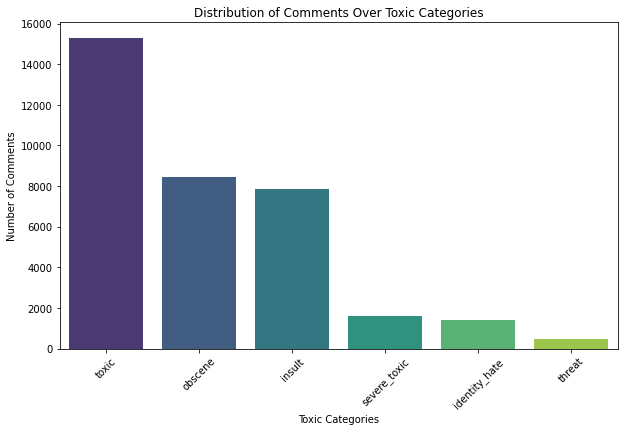

In [10]:
df = pd.read_csv("/dsa/data/DSA-8410/toxic/train.csv", encoding = "ISO-8859-1")
df.head(10)

# Inspecting the dataset to understand the columns
print(df.head()) 

# Assuming the toxic categories are in columns after the first one
toxic_categories = df.columns[2:]  # Adjust the index if needed

# Counting the number of comments for each toxic category
category_counts = df[toxic_categories].sum().sort_values(ascending=False)

# Plotting the distribution of comments over toxic categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribution of Comments Over Toxic Categories")
plt.xlabel("Toxic Categories")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()


### T2. Show a distribution of number of toxic categories per comment

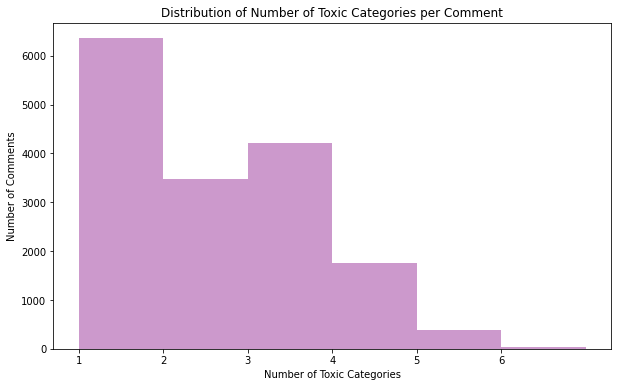

In [12]:
# Count the number of toxic categories per comment
df['toxic_count'] = df[toxic_categories].sum(axis=1)

# Plot the distribution of the number of toxic categories per comment
plt.figure(figsize=(10, 6))
sns.distplot(df['toxic_count'], bins=range(1, df['toxic_count'].max() + 2), kde=False, color='purple')
plt.title("Distribution of Number of Toxic Categories per Comment")
plt.xlabel("Number of Toxic Categories")
plt.ylabel("Number of Comments")
plt.xticks(range(1, df['toxic_count'].max() + 1))
plt.show()


### T3. Show a distribution of comment lenght in terms of characters

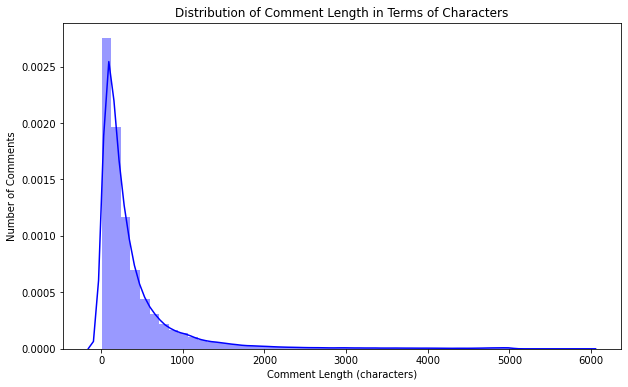

In [14]:
# Calculate the length of each comment
df['comment_length'] = df['comment_text'].apply(len)  # Replace 'comment_text' with your actual comment column name

# Plot the distribution of comment length
plt.figure(figsize=(10, 6))
sns.distplot(df['comment_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of Comment Length in Terms of Characters")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Number of Comments")
plt.show()


### T4. Show five randomly picked comments

In [15]:
# Display five randomly picked comments
random_comments = df['comment_text'].sample(5, random_state=42)  # Replace 'comment_text' with your actual comment column name
print(random_comments)

119105    Geez, are you forgetful!  We've already discus...
131631    Carioca RFA \n\nThanks for your support on my ...
125326    "\n\n Birthday \n\nNo worries, It's what I do ...
111256    Pseudoscience category? \n\nI'm assuming that ...
83590     (and if such phrase exists, it would be provid...
Name: comment_text, dtype: object


# Text cleaning

Let's use the following funciton as a black box for text cleaning. 

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### T5. Apply the above function and clean the comment texts. 

In [17]:
# Apply the clean_text function to the 'comment_text' column and create a new column for the cleaned text
df['cleaned_comment_text'] = df['comment_text'].apply(clean_text)  # Replace 'comment_text' with your actual comment column name

# Display the first few rows to verify the cleaning process
df[['comment_text', 'cleaned_comment_text']].head()

,comment_text,cleaned_comment_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i am s...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",more i can not make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


# Model development

### T6. Split data into train (80%) and test (20%)

In [19]:
from sklearn.model_selection import train_test_split

# Assuming 'cleaned_comment_text' is the feature and toxic categories are the labels
X = df['cleaned_comment_text']  # Features
y = df[toxic_categories]  # Labels (all toxic categories)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 127656
Testing set size: 31915


### T7. Define and train a multi-label (aka multioutput) classifier. Pick a suitable classifier as a base estimator. 

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TfidfVectorizer and LogisticRegression as the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))  # OneVsRestClassifier for multi-label classification
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=toxic_categories))


Accuracy: 0.9185962713457622
Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.61      0.73      3056
 severe_toxic       0.60      0.26      0.36       321
      obscene       0.92      0.61      0.73      1715
       threat       0.50      0.12      0.20        74
       insult       0.83      0.50      0.63      1614
identity_hate       0.74      0.13      0.22       294

    micro avg       0.88      0.54      0.67      7074
    macro avg       0.75      0.37      0.48      7074
 weighted avg       0.87      0.54      0.66      7074
  samples avg       0.06      0.05      0.05      7074



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### T8. Estimate accuracy

In [21]:
# Calculate accuracy for each label separately
label_accuracies = []
for i, label in enumerate(toxic_categories):
    label_accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    label_accuracies.append((label, label_accuracy))
    print(f"Accuracy for {label}: {label_accuracy:.4f}")

# Average accuracy across all labels
average_accuracy = sum([accuracy for _, accuracy in label_accuracies]) / len(label_accuracies)
print(f"Average accuracy across all labels: {average_accuracy:.4f}")

# Alternatively, overall accuracy (as calculated in T7)
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {overall_accuracy:.4f}")


Accuracy for toxic: 0.9572
Accuracy for severe_toxic: 0.9908
Accuracy for obscene: 0.9760
Accuracy for threat: 0.9977
Accuracy for insult: 0.9698
Accuracy for identity_hate: 0.9916
Average accuracy across all labels: 0.9805
Overall accuracy: 0.9186


## T9. Qualitative evaluation: Create a subset of comments where the number of predicted tags is three. Take the first ten comments and show their text, true toxic categories, and predicted categories. Write a brief comment about your observations.

In [25]:
import numpy as np

# Calculate the number of each type of toxic comments
predicted_label_counts = y_pred.sum(axis=1)

# Filter out comments with predicted count of 3
three_label_indices = np.where(predicted_label_counts == 3)[0]

# Pick up first 10 comments
subset_indices = three_label_indices[:10]

# Create a DataFrame including comment text, true labels, and predicted labels
subset = pd.DataFrame({
    'Comment Text': X_test.iloc[subset_indices],
    'True Labels': y_test.iloc[subset_indices].values.tolist(),
    'Predicted Labels': y_pred[subset_indices].tolist()
})

print(subset)


                                             Comment Text         True Labels  \
128796                          renzoy16 shut the fuck up  [1, 0, 1, 0, 1, 0]   
158055  you are a jerk you are a jerk you are a jerk y...  [1, 0, 1, 0, 1, 0]   
56556        your gay douche like gay porno ahaghagagagaa  [1, 0, 1, 0, 1, 1]   
62883                  listen up go fuck yourself asswipe  [1, 0, 1, 0, 1, 0]   
28027   you are a pompous juvenile self aggrandizing f...  [1, 0, 1, 0, 1, 0]   
125281  fred shut up you sad old twat no one is intere...  [1, 0, 1, 0, 1, 1]   
21349   take this how you will but you suck big black ...  [1, 0, 1, 0, 1, 0]   
155051  why are you still harassing me do you love bos...  [1, 0, 1, 0, 1, 1]   
24088       hello go fuck yourself kid adults are talking  [1, 1, 1, 0, 1, 0]   
3056        ram it up ur ass very hard till ur eyes water  [0, 0, 1, 0, 0, 0]   

          Predicted Labels  
128796  [1, 0, 1, 0, 1, 0]  
158055  [1, 0, 1, 0, 1, 0]  
56556   [1, 0, 0, 0, 

In [26]:
# Overall, the model has good performence in predicting toxic comments, but there is instability across different categories of comments. Especially when some comments have multiple category labels at the same time, the predicted labels may be inaccurate.

# Save your notebook, the `File > Close and Halt`